# Visualizing crypto market structure
Adapted from https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py

This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend to fluctuate in relation to each other during a day.


In [1]:
import time
import json

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import requests
from sklearn import covariance, cluster, manifold

### We examine Coindesk Market Index [coindesk](https://www.coindesk.com/indices/cmis)

### Price data from Coin Gecko [coin gecko](https://www.coingecko.com/)

In [10]:
constituents = pd.read_csv("constituents_coindesk_market_index.csv")
constituents = constituents.rename(columns=lambda x: x.lower())

with open('coingecko_list.json') as f:
    cg_data = json.load(f)

cg_names = pd.DataFrame.from_records(cg_data)
cg_names = cg_names.rename(columns={'name': 'cg_name'})

constituents = constituents.merge(cg_names, how="left", on='symbol')
constituents.to_csv("cg_constituents.csv")

In [29]:
constituents = pd.read_csv("cg_constituents_2.csv", index_col=0)

In [30]:
constituents

,symbol,name,dacs sector,dacs industry group,dacs industry,reconstitution weight,id,cg_name
0,1inch,1inch Network,DeFi,Exchanges,Exchanges (Other),0.032945,1inch,1inch
1,aave,Aave,DeFi,Credit Platform,Lending / Borrowing,0.108995,aave,Aave
2,aca,Acala Token,Smart Contract Platform,Layer 1,Layer 1,0.006482,acala,Acala
3,ach,Alchemy Pay,Currency,BaaS,Payments,0.011424,alchemy-pay,Alchemy Pay
4,acs,Access Protocol,Culture & Entertainment,Media,Social,0.007609,access-protocol,Access Protocol
...,...,...,...,...,...,...,...,...
279,xyo,XYO,Computing,Oracle,Oracle,0.006356,xyo-network,XYO Network
280,yfi,yearn.finance,DeFi,Yield,Yield,0.019512,yearn-finance,yearn.finance
281,ygg,Yield Guild Games,Culture & Entertainment,Metaverse,Metaverse Platform,0.009636,yield-guild-games,Yield Guild Games
282,zec,Zcash,Currency,Private,Private,0.035552,zcash,Zcash


In [31]:
constituents[constituents.symbol.duplicated()]

,symbol,name,dacs sector,dacs industry group,dacs industry,reconstitution weight,id,cg_name


## Load historical prices from Coin Gecko
## Dec 2022 - Dec 2023

In [ ]:
start = pd.Timestamp("2022-12-01T12:00:00")
end  = pd.Timestamp("2023-12-01T12:00:00")

results = []
for _, row in constituents.iterrows():
    time.sleep(21)
    token_id = row['id']
    name = row['name']
    print(f"token_id {token_id}")
    r = requests.get(f"https://api.coingecko.com/api/v3/coins/{token_id}/market_chart/range?vs_currency=USD&from={start.timestamp()}&to={end.timestamp()}")
    print(f"getting data for name {name}")
    resp = r.json()
    data = resp.get('prices')
    if (data is None) or (len(data) == 0):
        print(f"no data for ticker {name}")
        date_range = pd.date_range(start, end)
        nan_prices = np.empty((date_range.shape[0], ))
        nan_prices[:] = np.nan
        prices = pd.DataFrame({'date' : date_range, 'close': nan_prices})
    else:
        prices = pd.DataFrame(resp.get('prices')) 
        prices.columns = ["date", 'price']
    prices = prices.sort_values(by='date')
    prices["date"] = pd.to_datetime(prices.date, unit='ms', origin='unix')
    prices["name"] = name
    results.append(prices)

combined_data = pd.concat(results)

In [ ]:
combined_data.to_csv('cg_price_data_total.csv')

In [2]:
combined_data = pd.read_csv('cg_price_data_total.csv')
dataset = combined_data.pivot(index='date', columns='name', values='price')

In [3]:
dataset

name,0x,1inch Network,API3,ARPA,Aave,Aavegotchi,Acala Token,Access Protocol,Adventure Gold,Aergo,...,Vulcan Forged PYR,WOO Network,Waves,XRP,XYO,Yield Guild Games,Zcash,dYdX,iExec RLC,yearn.finance
date,,,,,,,,,,,,,,,,,,,,,
2022-12-02,0.194349,0.512787,1.475673,0.027956,63.589064,1.052975,0.113451,NaN,0.274698,0.116292,...,3.207968,0.124526,2.357454,0.398586,0.004324,0.224919,44.932667,NaN,1.086012,6681.304682
2022-12-03,0.193552,0.505770,1.507737,0.028853,65.527824,1.025667,0.155059,NaN,0.276957,0.116840,...,3.196139,0.125819,2.424383,0.398616,0.004322,0.242841,46.120687,NaN,1.099833,6819.861450
2022-12-04,0.190112,0.489838,1.463525,0.028155,62.874587,1.018137,0.137897,NaN,0.270616,0.114971,...,3.156363,0.122130,2.329474,0.389865,0.004268,0.235330,45.626442,NaN,1.076376,6640.284090
2022-12-05,0.197506,0.500704,1.476821,0.028863,64.518508,1.039546,0.136052,NaN,0.275633,0.114717,...,3.185474,0.123227,2.365142,0.392702,0.004415,0.239984,45.949654,NaN,1.097304,7338.261697
2022-12-06,0.191915,0.485993,1.451414,0.028394,64.355277,1.042089,0.132244,NaN,0.319110,0.112539,...,3.150201,0.122647,2.401339,0.390779,0.004299,0.230107,46.337661,NaN,1.065158,7166.505976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,0.401705,0.355181,1.461461,0.051936,98.052293,0.919328,0.059087,0.002301,0.926657,0.174821,...,6.353866,0.224329,2.137117,0.616851,0.003949,0.379643,29.523909,3.210250,1.527754,8533.514564
2023-11-28,0.391707,0.343751,1.410261,0.049584,96.196181,0.871273,0.063865,0.002209,0.843920,0.166301,...,6.059879,0.214906,2.095527,0.604080,0.003885,0.362481,28.808138,3.210250,1.460926,8443.978749
2023-11-29,0.396652,0.342631,1.475183,0.049815,96.854285,0.864136,0.063692,0.002344,0.825368,0.174062,...,5.946000,0.221407,2.105248,0.611266,0.003871,0.375681,28.890945,3.214087,1.479162,8468.222241


In [4]:
dataset = dataset.dropna(axis=1, how='any')

In [5]:
dataset

name,0x,1inch Network,API3,ARPA,Aave,Aavegotchi,Acala Token,Adventure Gold,Aergo,Akash Network,...,VeChain,Vulcan Forged PYR,WOO Network,Waves,XRP,XYO,Yield Guild Games,Zcash,iExec RLC,yearn.finance
date,,,,,,,,,,,,,,,,,,,,,
2022-12-02,0.194349,0.512787,1.475673,0.027956,63.589064,1.052975,0.113451,0.274698,0.116292,0.252062,...,0.019083,3.207968,0.124526,2.357454,0.398586,0.004324,0.224919,44.932667,1.086012,6681.304682
2022-12-03,0.193552,0.505770,1.507737,0.028853,65.527824,1.025667,0.155059,0.276957,0.116840,0.239293,...,0.019441,3.196139,0.125819,2.424383,0.398616,0.004322,0.242841,46.120687,1.099833,6819.861450
2022-12-04,0.190112,0.489838,1.463525,0.028155,62.874587,1.018137,0.137897,0.270616,0.114971,0.228143,...,0.019056,3.156363,0.122130,2.329474,0.389865,0.004268,0.235330,45.626442,1.076376,6640.284090
2022-12-05,0.197506,0.500704,1.476821,0.028863,64.518508,1.039546,0.136052,0.275633,0.114717,0.229625,...,0.019364,3.185474,0.123227,2.365142,0.392702,0.004415,0.239984,45.949654,1.097304,7338.261697
2022-12-06,0.191915,0.485993,1.451414,0.028394,64.355277,1.042089,0.132244,0.319110,0.112539,0.222067,...,0.019219,3.150201,0.122647,2.401339,0.390779,0.004299,0.230107,46.337661,1.065158,7166.505976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,0.401705,0.355181,1.461461,0.051936,98.052293,0.919328,0.059087,0.926657,0.174821,1.878847,...,0.022410,6.353866,0.224329,2.137117,0.616851,0.003949,0.379643,29.523909,1.527754,8533.514564
2023-11-28,0.391707,0.343751,1.410261,0.049584,96.196181,0.871273,0.063865,0.843920,0.166301,1.683940,...,0.021510,6.059879,0.214906,2.095527,0.604080,0.003885,0.362481,28.808138,1.460926,8443.978749
2023-11-29,0.396652,0.342631,1.475183,0.049815,96.854285,0.864136,0.063692,0.825368,0.174062,1.711161,...,0.021614,5.946000,0.221407,2.105248,0.611266,0.003871,0.375681,28.890945,1.479162,8468.222241


In [41]:
dataset.columns[dataset.isna().any()].tolist()

['Access Protocol',
 'Arbitrum',
 'Blur',
 'Echelon Prime',
 'Flare',
 'Pepe',
 'Sei',
 'Sui',
 'dYdX']

In [74]:
constituents['ticker'] = constituents['Symbol'].str.upper() + "-USD"

In [196]:
constituents['DACS Sector'].unique()

array(['DeFi', 'Smart Contract Platform', 'Currency',
       'Culture & Entertainment', 'Computing', 'Digitization'],
      dtype=object)

## Query Coinbase

In [169]:
def get_prices(ticker: str, start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:
    r = requests.get(f"https://api.pro.coinbase.com/products/{ticker}/candles?start={start.isoformat()}&end={end.isoformat()}&granularity=86400")
    resp = r.json()
    if isinstance(resp, list) and len(resp) > 0:
        print(f"found data from {ticker}")
        prices = pd.DataFrame(resp)
        prices.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
        prices['date'] = pd.to_datetime(prices['time'], origin="unix", unit='s')
    else:
        print(f"no data for ticker {ticker}")
        date_range = pd.date_range(start, end)
        nan_prices = np.empty((date_range.shape[0], ))
        nan_prices[:] = np.nan
        prices = pd.DataFrame({'date' : date_range, 'close': nan_prices})
    prices = prices.sort_values(by='date')
    prices["ticker"] = ticker
    return prices[['date', 'ticker', 'close']]

start = pd.Timestamp("2022-12-01T00:00:00")
mid = pd.Timestamp("2023-06-01T00:00:00")
end = pd.Timestamp("2023-12-01T00:00:00")

prices = []
for ticker in constituents.ticker:
    print(f"get prices for: {ticker}")
    batch_1 = get_prices(ticker, start, mid)
    batch_2 = get_prices(ticker, mid + pd.Timedelta(hours=24), end)
    prices.append(pd.concat([batch_1, batch_2]))

dataset = pd.concat(prices)
dataset = dataset.pivot(index='date', columns='ticker', values='close')
# dataset = dataset.dropna(axis=1, how='all')



## Learning a graph structure

We use sparse inverse covariance estimation to find which quotes are
correlated conditionally on the others. Specifically, sparse inverse
covariance gives us a graph, that is a list of connections. For each
symbol, the symbols that it is connected to are those useful to explain
its fluctuations.



In [6]:
rets = dataset.pct_change().iloc[1:]
cov = rets.cov()
corrs = rets.corr()

In [11]:
corrs

name,0x,1inch Network,API3,ARPA,Aave,Aavegotchi,Acala Token,Adventure Gold,Aergo,Akash Network,...,VeChain,Vulcan Forged PYR,WOO Network,Waves,XRP,XYO,Yield Guild Games,Zcash,iExec RLC,yearn.finance
name,,,,,,,,,,,,,,,,,,,,,
0x,1.000000,0.480426,0.383373,0.316090,0.427994,0.343896,0.360710,0.255271,0.360562,0.201360,...,0.531142,0.463809,0.497893,0.361325,0.261317,0.185179,0.365563,0.500203,0.417898,0.492991
1inch Network,0.480426,1.000000,0.469844,0.426073,0.602683,0.423252,0.440735,0.314126,0.381779,0.289833,...,0.695071,0.545411,0.598179,0.475401,0.390082,0.240985,0.436646,0.675457,0.548477,0.502687
API3,0.383373,0.469844,1.000000,0.328556,0.466408,0.251961,0.336112,0.327960,0.249912,0.230707,...,0.504039,0.350238,0.505052,0.363760,0.263234,0.206194,0.412750,0.514119,0.431512,0.369841
ARPA,0.316090,0.426073,0.328556,1.000000,0.385009,0.286115,0.257378,0.301811,0.268363,0.176252,...,0.464566,0.348572,0.408413,0.361564,0.232472,0.156902,0.321047,0.453386,0.417599,0.304999
Aave,0.427994,0.602683,0.466408,0.385009,1.000000,0.350386,0.401097,0.334803,0.344891,0.274194,...,0.691193,0.503642,0.598896,0.409034,0.331260,0.254679,0.441184,0.662403,0.529403,0.487604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYO,0.185179,0.240985,0.206194,0.156902,0.254679,0.126711,0.161212,0.133420,0.189415,0.114217,...,0.266852,0.180789,0.210058,0.183809,0.124281,1.000000,0.205622,0.316865,0.262540,0.186897
Yield Guild Games,0.365563,0.436646,0.412750,0.321047,0.441184,0.376015,0.348868,0.314454,0.281541,0.213456,...,0.502372,0.455424,0.401676,0.328322,0.197564,0.205622,1.000000,0.452368,0.366085,0.339870
Zcash,0.500203,0.675457,0.514119,0.453386,0.662403,0.440479,0.446945,0.399091,0.379251,0.355288,...,0.747307,0.492559,0.642808,0.494017,0.495878,0.316865,0.452368,1.000000,0.604746,0.506381


In [12]:
cov.values

array([[0.00299877, 0.00097596, 0.00115889, ..., 0.00090514, 0.00098033,
        0.00117595],
       [0.00097596, 0.00137615, 0.00096213, ..., 0.000828  , 0.00087161,
        0.00081228],
       [0.00115889, 0.00096213, 0.00304718, ..., 0.0009378 , 0.00102041,
        0.00088928],
       ...,
       [0.00090514, 0.000828  , 0.0009378 , ..., 0.00109194, 0.00085606,
        0.00072887],
       [0.00098033, 0.00087161, 0.00102041, ..., 0.00085606, 0.00183511,
        0.00089414],
       [0.00117595, 0.00081228, 0.00088928, ..., 0.00072887, 0.00089414,
        0.00189737]])

In [ ]:
plt.figure(1, figsize=(8, 8))
plt.imshow(
    cov.values, interpolation="nearest", vmin=-cov.max(), vmax=cov.max(), cmap=plt.cm.RdBu_r
)
plt.xticks(())
plt.yticks(())
plt.title("emp covariance")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [
    ("Empirical", emp_cov),
    #("Ledoit-Wolf", lw_cov_),
    ("GraphicalLassoCV", cov_),
    #("True", cov),
]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        this_cov, interpolation="nearest", vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s covariance" % name)


# plot the precisions
precs = [
    ("Empirical", linalg.inv(emp_cov)),
    ("Ledoit-Wolf", lw_prec_),
    ("GraphicalLasso", prec_),
    ("True", prec),
]
vmax = 0.9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(
        np.ma.masked_equal(this_prec, 0),
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
        cmap=plt.cm.RdBu_r,
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s precision" % name)
    if hasattr(ax, "set_facecolor"):
        ax.set_facecolor(".7")
    else:
        ax.set_axis_bgcolor(".7")

In [9]:
X = rets.values 
emp_cov = covariance.EmpiricalCovariance()

emp_cov.fit(X)
emp_cov.covariance_

array([[0.00299053, 0.00097328, 0.00115571, ..., 0.00090266, 0.00097764,
        0.00117272],
       [0.00097328, 0.00137237, 0.00095949, ..., 0.00082572, 0.00086922,
        0.00081005],
       [0.00115571, 0.00095949, 0.00303881, ..., 0.00093523, 0.0010176 ,
        0.00088684],
       ...,
       [0.00090266, 0.00082572, 0.00093523, ..., 0.00108894, 0.00085371,
        0.00072687],
       [0.00097764, 0.00086922, 0.0010176 , ..., 0.00085371, 0.00183007,
        0.00089169],
       [0.00117272, 0.00081005, 0.00088684, ..., 0.00072687, 0.00089169,
        0.00189216]])

In [13]:
emp_cov.precision_

array([[ 1.43770409e+03, -1.13749751e+01, -1.71665617e+02, ...,
         3.25484816e+02, -8.34766717e+01, -4.76419162e+02],
       [-1.13749751e+01,  3.57200540e+03, -1.49205413e+02, ...,
        -6.00892380e+02, -8.82554986e+01,  1.74463968e+02],
       [-1.71665617e+02, -1.49205413e+02,  1.14009455e+03, ...,
        -1.37442481e+02,  2.45825174e+01, -3.39223880e+01],
       ...,
       [ 3.25484816e+02, -6.00892380e+02, -1.37442481e+02, ...,
         7.25304502e+03, -6.11595313e+00, -2.05315525e+01],
       [-8.34766717e+01, -8.82554986e+01,  2.45825174e+01, ...,
        -6.11595313e+00,  2.36908260e+03, -1.92595395e+02],
       [-4.76419162e+02,  1.74463968e+02, -3.39223880e+01, ...,
        -2.05315525e+01, -1.92595395e+02,  2.36228307e+03]])

In [ ]:
#alphas = np.logspace(-1.5, 1, num=10)
#edge_model = covariance.GraphicalLassoCV(alphas=alphas)

# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery
# X = variation.copy().T
# X /= X.std(axis=0)

#edge_model.fit(X)

In [71]:
cov.values

array([[0.00299877, 0.00097596, 0.00115889, ..., 0.00090514, 0.00098033,
        0.00117595],
       [0.00097596, 0.00137615, 0.00096213, ..., 0.000828  , 0.00087161,
        0.00081228],
       [0.00115889, 0.00096213, 0.00304718, ..., 0.0009378 , 0.00102041,
        0.00088928],
       ...,
       [0.00090514, 0.000828  , 0.0009378 , ..., 0.00109194, 0.00085606,
        0.00072887],
       [0.00098033, 0.00087161, 0.00102041, ..., 0.00085606, 0.00183511,
        0.00089414],
       [0.00117595, 0.00081228, 0.00088928, ..., 0.00072887, 0.00089414,
        0.00189737]])

## Clustering using affinity propagation

We use clustering to group together quotes that behave similarly. Here,
amongst the various clustering techniques <clustering> available
in the scikit-learn, we use `affinity_propagation` as it does
not enforce equal-size clusters, and it can choose automatically the
number of clusters from the data.

Note that this gives us a different indication than the graph, as the
graph reflects conditional relations between variables, while the
clustering reflects marginal properties: variables clustered together can
be considered as having a similar impact at the level of the full stock
market.

In [13]:
# _, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
# _, labels = cluster.affinity_propagation(cov.values, random_state=0)
_, labels = cluster.affinity_propagation(emp_cov.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(cov.index.values[labels == i])}")

Cluster 1: 0x, ARPA, Aave, Aavegotchi, Aergo, Akash Network, Alchemy Pay, Algorand, Alpha Coin, Amp, Ampleforth Governance Token, Ankr, Aptos, Artificial Liquid Intelligence, Astar, Audius, Avalanche, Axie Infinity, Badger DAO, Balancer, Bancor, Band Protocol, BarnBridge, Basic Attention Token, Biconomy, Bitcoin, Bitcoin Cash, Bluzelle, COTI, Cardano, Cartesi, Celer Network, Chainlink, Chiliz, Chromia, Civic, Coin98, Compound, Convex Finance, Cosmos, Covalent, Cronos, Dash, Decentraland, Dogecoin, Dogelon Mars, EOS, Enjin Coin, Enzyme, Ethereum Classic, Ethereum Name Service, Ethernity Chain, Fantom, Fetch.ai, Filecoin, Flow, Frax Share, GMT, GMX, Galxe, Gitcoin, Gods Unchained, Golem, Hashflow, Hedera, Helium, Highstreet, ICON, IDEX, Illuvium, Immutable X, Injective, Internet Computer, IoTeX, JasmyCoin, Kava, Kusama, Kyber Network Crystal, Lido DAO, Liquity, Lisk, Litecoin, Litentry, Livepeer, Loopring, MAGIC, Mask Network, Mina, Mines of Dalarnia, Moonbeam, Moonriver, MultiversX, My 

## Embedding in 2D space

For visualization purposes, we need to lay out the different symbols on a
2D canvas. For this we use `manifold` techniques to retrieve 2D
embedding.
We use a dense eigen_solver to achieve reproducibility (arpack is initiated
with the random vectors that we don't control). In addition, we use a large
number of neighbors to capture the large-scale structure.



In [11]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=10
)

embedding = node_position_model.fit_transform(X.T).T

In [21]:
embedding.shape

(2, 175)

In [24]:
embedding

array([[ 4.04219899e-02, -7.26392957e-03,  2.96781107e-02,
         3.53373170e-02, -3.67325215e-02, -7.67977247e-02,
         2.56532596e-04,  1.55405349e-01, -4.03270403e-02,
         6.16561563e-02, -4.16009683e-02,  4.37179425e-02,
         4.00884056e-02,  4.93509292e-02, -5.66235260e-02,
        -6.25196249e-02,  2.41756919e-02,  2.64327141e-02,
         4.56077705e-02, -1.21242585e-01,  5.87957240e-02,
        -8.49940536e-03,  6.95676921e-03, -3.94230801e-02,
        -9.49082368e-03, -1.15656547e-01,  1.28445477e-01,
        -2.29455854e-01, -1.12172862e-01,  2.46462862e-02,
         5.24845053e-02, -3.19279660e-02,  3.93290638e-02,
        -2.40719835e-02, -1.93946619e-01, -7.02857070e-02,
         8.11257700e-02,  5.83580244e-03, -5.31230647e-02,
         6.08934593e-02,  3.47117681e-02,  2.46441401e-03,
         1.08326757e-01,  9.67423678e-02,  1.03535416e-02,
         9.26642759e-02, -4.79976014e-04, -9.27885326e-02,
        -2.73005900e-02, -5.49454065e-02, -8.56495849e-0

## Visualization

The output of the 3 models are combined in a 2D graph where nodes
represents the stocks and edges the:

- cluster labels are used to define the color of the nodes
- the sparse covariance model is used to display the strength of the edges
- the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as
visualization is crucial here to display the graph. One of the challenge
is to position the labels minimizing overlap. For this we use an
heuristic based on the direction of the nearest neighbor along each
axis.



In [26]:
labels

array([0, 8, 7, 0, 0, 0, 7, 8, 0, 0, 7, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0,
       0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 8, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 0, 8, 8, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 7, 0, 0, 3, 0, 0, 0, 0, 5, 0,
       0, 0, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 7,
       0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3])

In [49]:
X_embedded = manifold.TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
embedding_2 = X_embedded.fit_transform(X.T).T

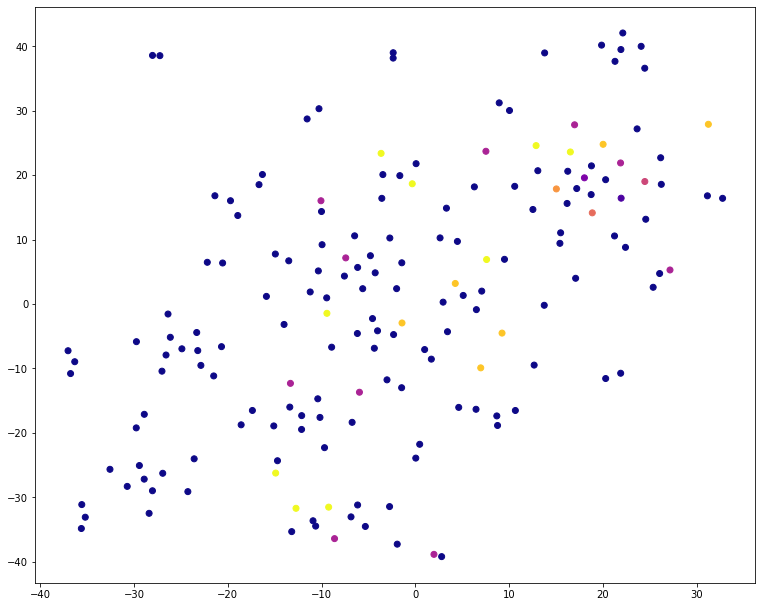

In [51]:
plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
# plt.axis("off")

# Plot the graph of partial correlations
# partial_correlations = edge_model.precision_.copy()
partial_correlations = emp_cov.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding_2[0], embedding_2[1], c=labels, cmap=plt.cm.plasma
    #embedding_2[0], embedding_2[1], s=400 * d**2, c=labels, cmap=plt.cm.plasma
)

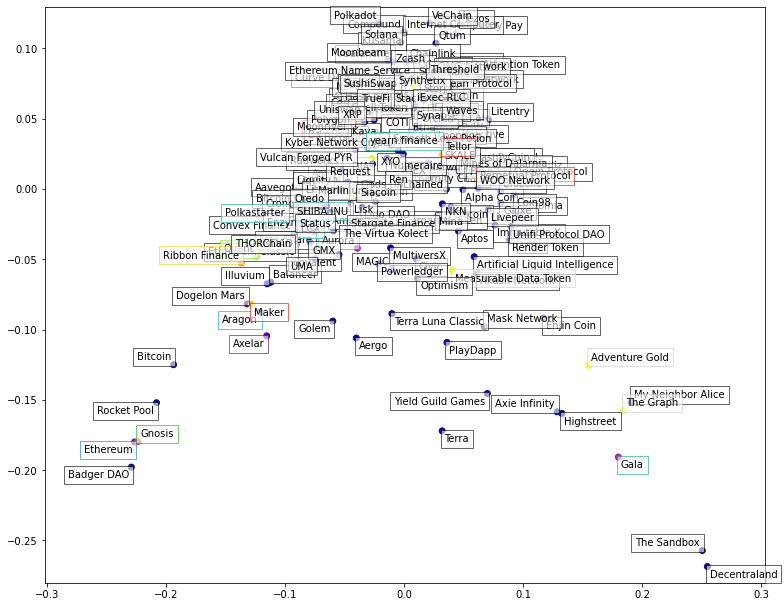

In [14]:
plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
# plt.axis("off")

# Plot the graph of partial correlations
# partial_correlations = edge_model.precision_.copy()
partial_correlations = emp_cov.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    #embedding[0], embedding[1], s=400 * d**2, c=labels, cmap=plt.cm.plasma
    embedding[0], embedding[1], c=labels, cmap=plt.cm.plasma
)

names = cov.index.values
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()

In [44]:
d[13]

2.3504618261135923

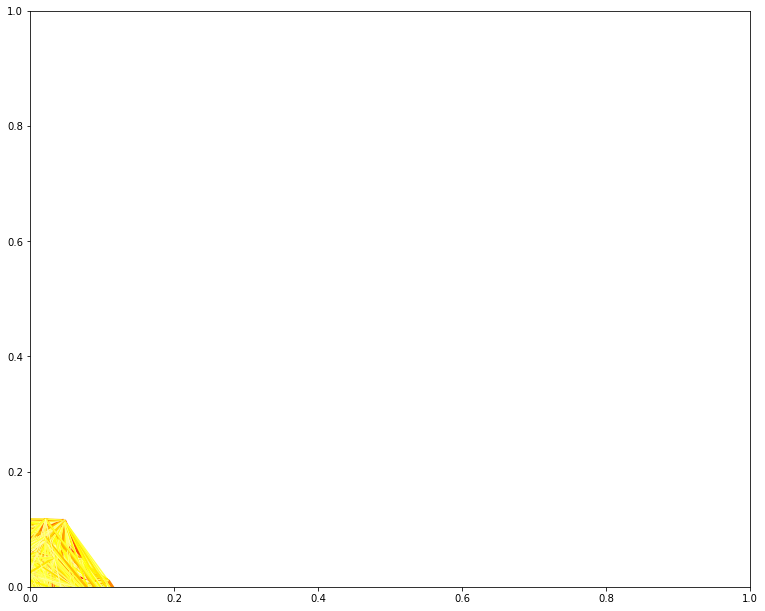

In [45]:
plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])

start_idx, end_idx = np.where(non_zero)
## a sequence of (*line0*, *line1*, *line2*), where::
##            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])

lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)
plt.show()

ValueError: s must be a scalar, or float array-like with the same size as x and y

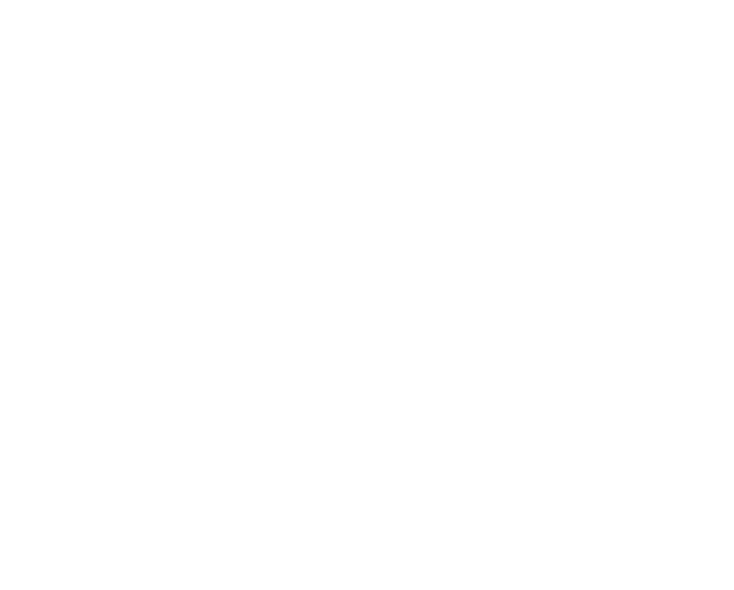

In [18]:
plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
# partial_correlations = edge_model.precision_.copy()
partial_correlations = emp_cov.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

## Plot the edges
#start_idx, end_idx = np.where(non_zero)
## a sequence of (*line0*, *line1*, *line2*), where::
##            linen = (x0, y0), (x1, y1), ... (xm, ym)
#segments = [
#    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
#]
#values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
names = cov.index.values
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()